In [1]:
import os
import io

import numpy as np
from tqdm import tqdm

import cv2
import glob
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Configuration

In [34]:
DATA_DIR = "./original/"
NEW_DATA_DIR = "./processed_512/"

if not os.path.exists(NEW_DATA_DIR):
    os.makedirs(os.path.join(NEW_DATA_DIR, "train"))
    os.makedirs(os.path.join(NEW_DATA_DIR, "val"))
    os.makedirs(os.path.join(NEW_DATA_DIR, "test"))

# 1. Example

## 1.2 [12.jpeg] with 4 classes

(480, 640, 4)
[0.        0.5019608 1.       ]


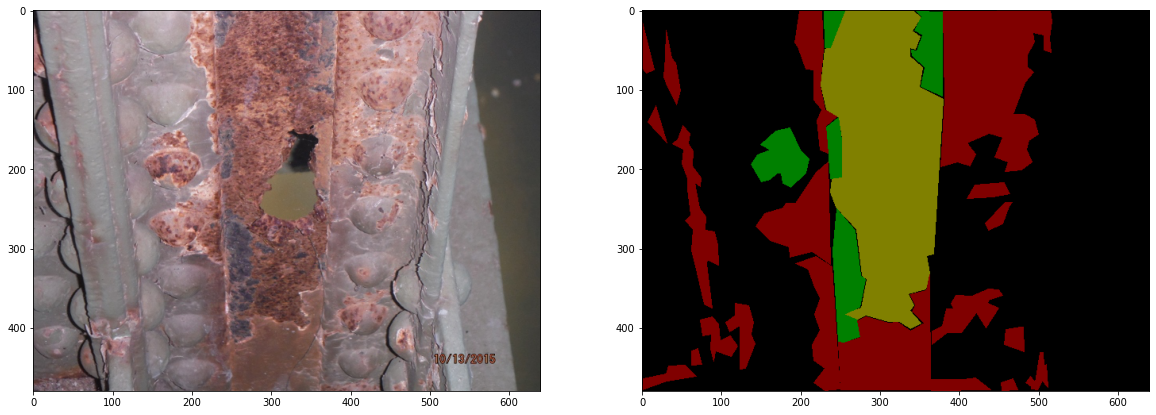

In [3]:
f = os.path.join(DATA_DIR,"Train/images/12.jpeg")
img = plt.imread(f)
mask_ = plt.imread(os.path.join(os.path.join(DATA_DIR,"Train/masks/"), os.path.basename(f)[:-5]+".png"))

plt.figure(figsize=(20,10))
plt.subplot(121); plt.imshow(img)
plt.subplot(122); plt.imshow(mask_)

print(mask_.shape)
print(np.unique(mask_))

## 1.2 original labels

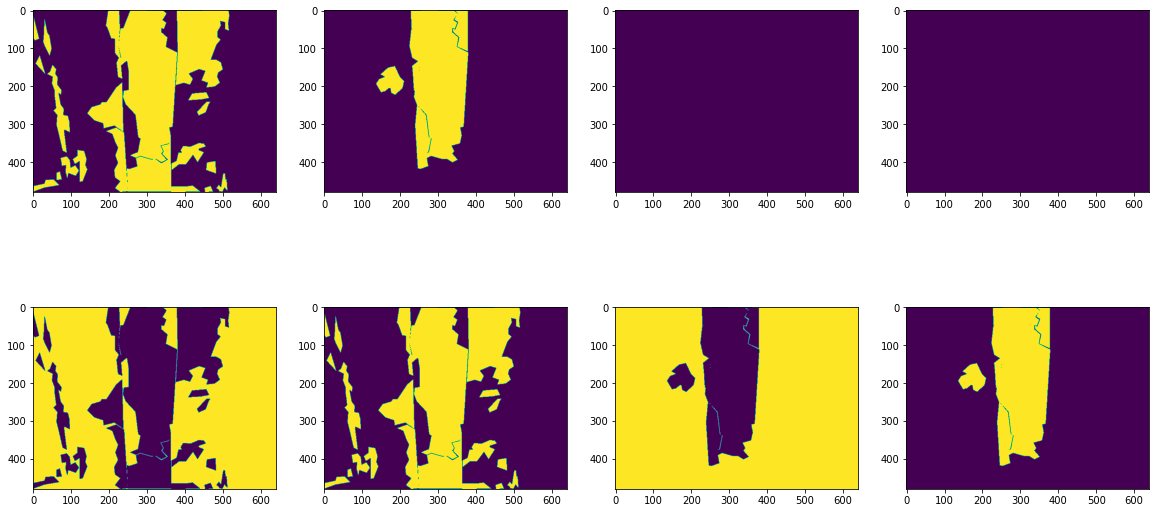

In [4]:
plt.figure(figsize=(20,10))
plt.subplot(241); plt.imshow(mask_[:,:,0])
plt.subplot(242); plt.imshow(mask_[:,:,1])
plt.subplot(243); plt.imshow(mask_[:,:,2])
plt.subplot(244); plt.imshow(mask_[:,:,3])

plt.subplot(245); idx = np.where(mask_[:,:,0]==0.); tmp = np.zeros(mask_.shape[:2]); tmp[idx]=1; plt.imshow(tmp)
plt.subplot(246); idx = np.where(mask_[:,:,0]==0.5019608); tmp = np.zeros(mask_.shape[:2]); tmp[idx]=1; plt.imshow(tmp)
plt.subplot(247); idx = np.where(mask_[:,:,1]==0.); tmp = np.zeros(mask_.shape[:2]); tmp[idx]=1; plt.imshow(tmp)
plt.subplot(248); idx = np.where(mask_[:,:,1]==0.5019608); tmp = np.zeros(mask_.shape[:2]); tmp[idx]=1; plt.imshow(tmp)

## 1.3 label conversion

In [5]:
# mask = cv2.imread(os.path.join(os.path.join(DATA_DIR,"Train/masks/"), os.path.basename(f)[:-5]+".png"), 0)

# labels = []
# for v in np.unique(mask):
#     if v == 0:
#         continue
#     idx = np.where(mask == v)
#     tmp = np.zeros(mask.shape)
#     tmp[idx] = 1
#     labels.append(tmp)
    
# labels = np.stack(labels, axis=-1)

# plt.figure(figsize=(20,10))
# plt.subplot(1,labels.shape[2]+1,1); plt.imshow(mask); plt.title("raw mask")
# for i in range(2,labels.shape[2]+2):
#     plt.subplot(1,labels.shape[2]+1,i); plt.imshow(labels[:,:,i-2], interpolation='nearest'); plt.title(f"class {i-1}")

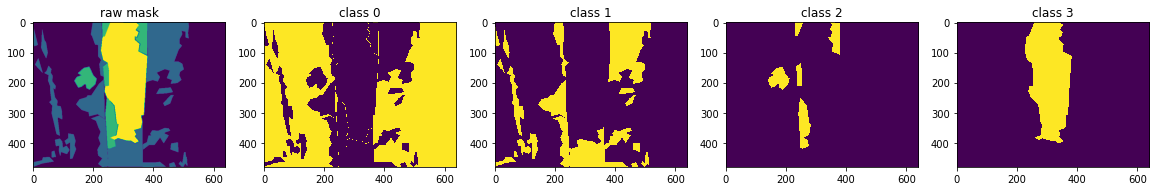

In [6]:
mask = cv2.imread(os.path.join(os.path.join(DATA_DIR,"Train/masks/"), os.path.basename(f)[:-5]+".png"), 0)

label = np.zeros(mask.shape)
for i,v in enumerate(np.unique(mask)):
    if i == 0:
        continue
    idx = np.where(mask == v)
    label[idx] = i
    
plt.figure(figsize=(20,10))
plt.subplot(1,len(np.unique(mask))+1,1); plt.imshow(mask); plt.title("raw mask")
for i in range(2,len(np.unique(mask))+2):
    plt.subplot(1,len(np.unique(mask))+1,i)
    idx = np.where(label == i-2)
    tmp = np.zeros(label.shape[:2])
    tmp[idx] = 1
    plt.imshow(tmp, interpolation='nearest'); plt.title(f"class {i-2}")

## 1.4 instantiation

In [7]:
f1 = open( os.path.join(os.path.join(DATA_DIR,"Train/json/"), os.path.basename(f)[:-5]+".json") )
mask_json = json.load(f1)
f1.close()

print(mask_json)

{'version': '4.5.6', 'flags': {}, 'shapes': [{'label': '4_Severe_Steel_Corrosion', 'points': [[256.9219143576826, 0.0], [237.77833753148616, 47.60705289672544], [230.22166246851384, 49.1183879093199], [225.68765743073044, 94.96221662468514], [232.4886649874055, 125.1889168765743], [248.86146095717885, 135.26448362720402], [252.89168765743074, 162.46851385390428], [250.12090680100755, 210.83123425692693], [239.03778337531486, 213.09823677581863], [237.52644836272037, 229.21914357682618], [244.07556675062972, 248.36272040302265], [270.272040302267, 276.32241813602013], [277.07304785894206, 334.0050377833753], [283.3702770780856, 339.54659949622163], [276.82115869017633, 375.5667506297229], [255.91435768261965, 382.11586901763224], [270.272040302267, 390.93198992443325], [282.36272040302265, 384.63476070528964], [310.32241813602013, 392.9471032745592], [324.176322418136, 392.6952141057934], [338.7858942065491, 401.76322418136016], [351.632241813602, 394.96221662468514], [337.7783375314861

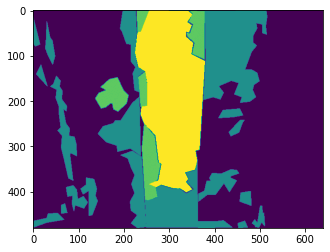

In [8]:
img_tmp = np.zeros(mask.shape[:2])

for i in range(len(mask_json['shapes'])):
    points = np.array(mask_json['shapes'][i]['points']).astype(np.int32)
    cv2.fillPoly(img_tmp, pts=[points], color=int(mask_json['shapes'][i]['label'][0]))
    
plt.imshow(img_tmp)

In [9]:
labels = []
for i in range(len(mask_json['shapes'])):
    img_tmp = np.zeros(mask.shape[:2])
    points = np.array(mask_json['shapes'][i]['points']).astype(np.int32)
    cv2.fillPoly(img_tmp, pts=[points], color=int(mask_json['shapes'][i]['label'][0]))
    labels.append(img_tmp)
    
labels = np.stack(labels, axis=-1)
labels.shape

(480, 640, 26)

(480, 640)
[0. 2.]


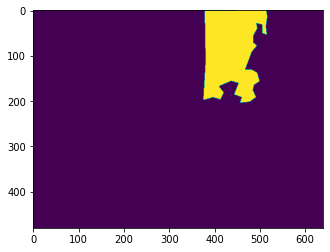

In [74]:
print(labels[:,:,7].shape)
plt.imshow(labels[:,:,7])
print(np.unique(labels[:,:,7]))

(512, 512)
[0.        0.0078125 0.0234375 0.0390625 0.0546875 0.0625    0.0703125
 0.1015625 0.1171875 0.1328125 0.1484375 0.1640625 0.1796875 0.1875
 0.1953125 0.2109375 0.2265625 0.2421875 0.25      0.2578125 0.2734375
 0.3046875 0.3125    0.3515625 0.3828125 0.3984375 0.4296875 0.4375
 0.4453125 0.5078125 0.5234375 0.5390625 0.5625    0.5859375 0.6015625
 0.6328125 0.6640625 0.6796875 0.6875    0.7109375 0.7265625 0.7421875
 0.75      0.8125    0.8203125 0.8515625 0.8671875 0.8984375 0.9296875
 0.9375    0.9453125 0.9609375 0.9765625 1.0234375 1.0390625 1.0546875
 1.0625    1.0703125 1.1015625 1.1328125 1.1484375 1.1796875 1.1875
 1.25      1.2578125 1.2734375 1.2890625 1.3125    1.3203125 1.3359375
 1.3671875 1.3984375 1.4140625 1.4375    1.4609375 1.4765625 1.5078125
 1.5546875 1.5625    1.5703125 1.5859375 1.6015625 1.6171875 1.6484375
 1.6875    1.6953125 1.7265625 1.7421875 1.75      1.7578125 1.7734375
 1.7890625 1.8046875 1.8125    1.8203125 1.8359375 1.8515625 1.8671875
 1.8

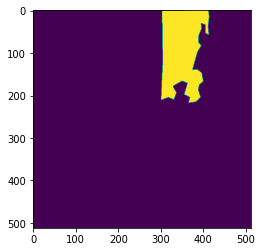

In [80]:
tmp = cv2.resize(labels[:,:,7], (512,512), cv2.INTER_NEAREST)
print(tmp.shape)
plt.imshow(tmp)
print(np.unique(tmp))

(512, 512)
[0. 2.]


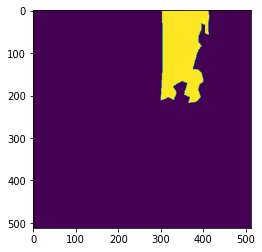

In [86]:
tmp = cv2.resize(labels[:,:,7], (512,512), cv2.INTER_NEAREST)
ret,thresh1 = cv2.threshold(tmp,0,np.max(tmp),cv2.THRESH_BINARY)

print(thresh1.shape)
plt.imshow(thresh1)
print(np.unique(thresh1))

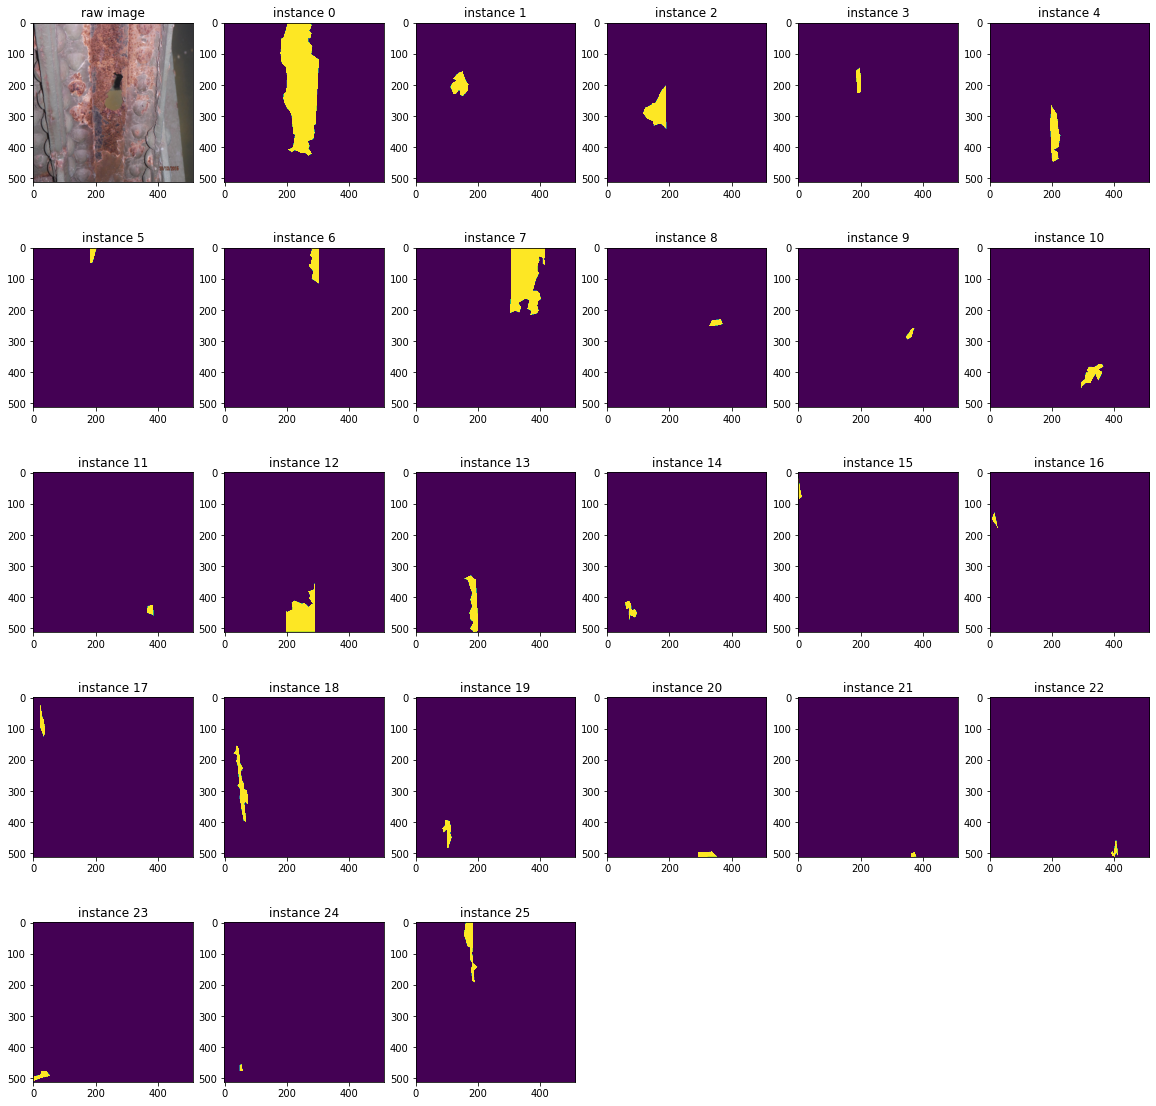

In [32]:
plt.figure(figsize=(20,20))
plt.subplot(5,6,1); 
tmp = cv2.resize(img, (512,512)); 
plt.imshow(tmp); plt.title("raw image")

for i in range(2,labels.shape[2]+2):
    plt.subplot(5,6,i); 
    tmp = cv2.resize(labels[:,:,i-2], (512,512))
    plt.imshow(tmp, interpolation='nearest'); plt.title(f"instance {i-2}")

# 2. For [Train] Data

## 2.1 data split to [train, val]

In [35]:
X = np.sort(glob.glob(os.path.join(DATA_DIR,"Train/images/*")))
y = np.sort(glob.glob(os.path.join(DATA_DIR,"Train/masks/*")))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train[:5])
print(y_train[:5])

['./original/Train/images/46.jpeg' './original/Train/images/256.jpeg'
 './original/Train/images/155.jpeg' './original/Train/images/320.jpeg'
 './original/Train/images/302.jpeg']
['./original/Train/masks/46.png' './original/Train/masks/256.png'
 './original/Train/masks/155.png' './original/Train/masks/320.png'
 './original/Train/masks/302.png']


In [36]:
y_ = np.sort(glob.glob(os.path.join(DATA_DIR,"Train/json/*")))

X_train, X_val, y_train, y_val = train_test_split(X, y_, test_size=0.2, random_state=42)
print(X_train[:5])
print(y_train[:5])

['./original/Train/images/46.jpeg' './original/Train/images/256.jpeg'
 './original/Train/images/155.jpeg' './original/Train/images/320.jpeg'
 './original/Train/images/302.jpeg']
['./original/Train/json/46.json' './original/Train/json/256.json'
 './original/Train/json/155.json' './original/Train/json/320.json'
 './original/Train/json/302.json']


## 2.2 label conversion

In [87]:
def convert_mask(mask):
#     labels = []
#     for v in np.unique(mask):
#         if v == 0:
#             continue
#         idx = np.where(mask == v)
#         tmp = np.zeros(mask.shape)
#         tmp[idx] = 1
#         labels.append(tmp)

#     return np.stack(labels, axis=-1)

    label = np.zeros(mask.shape)
    for i,v in enumerate(np.unique(mask)):
        if i == 0:
            continue
        idx = np.where(mask == v)
        label[idx] = i
        
    return label

def convert_mask_json(mask, mask_json, resize=False, redst=(512,512)):
    labels = []
    for i in range(len(mask_json['shapes'])):
        img_tmp = np.zeros(mask.shape[:2])
        points = np.array(mask_json['shapes'][i]['points']).astype(np.int32)
        cv2.fillPoly(img_tmp, pts=[points], color=int(mask_json['shapes'][i]['label'][0])-1)
        
        if resize:
            img_tmp = cv2.resize(img_tmp, redst)
            ret,img_tmp = cv2.threshold(img_tmp,0,np.max(img_tmp),cv2.THRESH_BINARY)

        labels.append(img_tmp)

    return np.stack(labels, axis=-1)

In [89]:
for i,f in enumerate(X_train):
    img = cv2.imread(f)
#     mask = cv2.imread(y_train[i], 0)
    with open(y_train[i]) as f1:
        mask_json = json.load(f1)
    
#     label = convert_mask(mask)
    label = convert_mask_json(img, mask_json, resize=True, redst=(512,512))
    img = cv2.resize(img, (512,512))
    
    cv2.imwrite(os.path.join(NEW_DATA_DIR+"train/", os.path.basename(f)), img)
    np.save(os.path.join(NEW_DATA_DIR+"train/", os.path.basename(f)[:-5]+".npy"), label)

In [90]:
for i,f in enumerate(X_val):
    img = cv2.imread(f)
#     mask = cv2.imread(y_val[i], 0)
    with open(y_val[i]) as f1:
        mask_json = json.load(f1)
    
#     label = convert_mask(mask)
    label = convert_mask_json(img, mask_json, resize=True, redst=(512,512))
    img = cv2.resize(img, (512,512))
    
    cv2.imwrite(os.path.join(NEW_DATA_DIR+"val/", os.path.basename(f)), img)
    np.save(os.path.join(NEW_DATA_DIR+"val/", os.path.basename(f)[:-5]+".npy"), label)

(512, 512, 5)


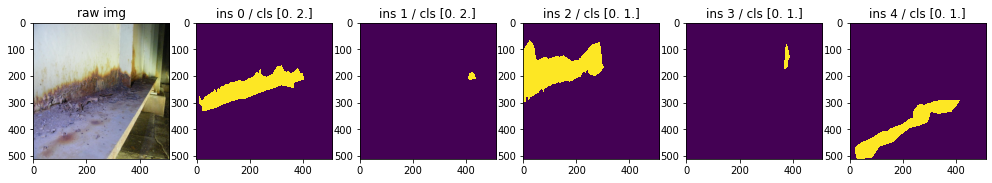

In [91]:
testnum = 4
img = plt.imread(os.path.join(NEW_DATA_DIR,"train/"+str(testnum)+".jpeg"))
mask = np.load(os.path.join(NEW_DATA_DIR,"train/"+str(testnum)+".npy"))

print(mask.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,mask.shape[2]+2,1); plt.imshow(img); plt.title("raw img")

for i in range(2,mask.shape[2]+2):
    plt.subplot(1,mask.shape[2]+2,i)
    plt.imshow(mask[:,:,i-2], interpolation='nearest'); plt.title(f"ins {i-2} / cls {np.unique(mask[:,:,i-2])}")

# 3. For [Test] Data

In [88]:
X = np.sort(glob.glob(os.path.join(DATA_DIR,"Test/images/*")))
# y = np.sort(glob.glob(os.path.join(DATA_DIR,"Test/masks/*")))
y = np.sort(glob.glob(os.path.join(DATA_DIR,"Test/json/*")))

for i,f in enumerate(X):
    img = cv2.imread(f)

#     mask = cv2.imread(y[i], 0)    
    with open(y[i]) as f1:
        mask_json = json.load(f1)
    
#     label = convert_mask(mask)
    label = convert_mask_json(img, mask_json, resize=True, redst=(512,512))
    img = cv2.resize(img, (512,512))
    
    cv2.imwrite(os.path.join(NEW_DATA_DIR+"test/", os.path.basename(f)), img)
    np.save(os.path.join(NEW_DATA_DIR+"test/", os.path.basename(f)[:-5]+".npy"), label)

# 4. Verification

In [69]:
print("train")
print(len(glob.glob(os.path.join(NEW_DATA_DIR,"train/*.jpeg"))))
print(len(glob.glob(os.path.join(NEW_DATA_DIR,"train/*.npy"))))

print("\nval")
print(len(glob.glob(os.path.join(NEW_DATA_DIR,"val/*.jpeg"))))
print(len(glob.glob(os.path.join(NEW_DATA_DIR,"val/*.npy"))))

print("\ntest")
print(len(glob.glob(os.path.join(NEW_DATA_DIR,"test/*.jpeg"))))
print(len(glob.glob(os.path.join(NEW_DATA_DIR,"test/*.npy"))))

train
316
316

val
80
80

test
44
44


(1536, 2048, 12)


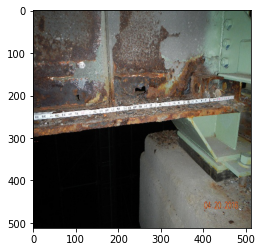

In [50]:
testnum = 7
img = plt.imread(os.path.join(NEW_DATA_DIR,"test/"+str(testnum)+".jpeg"))
mask = np.load(os.path.join(NEW_DATA_DIR,"test/"+str(testnum)+".npy"))

plt.imshow(img)
print(mask.shape)

In [106]:
np.unique(mask)

array([0., 1., 2., 3.])

In [87]:
mask.shape

(1536, 2048, 12)

In [88]:
mask.shape[-1]

12

In [90]:
np.ones([mask.shape[-1]])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [94]:
class_ids = []
for i in range(mask.shape[-1]):
    class_id = np.unique(mask[:,:,i])
    class_ids.append(class_id[1])

np.array(class_ids).astype(np.int32)

[3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0]

In [114]:
min_ = 10000
max_ = 0

for f in glob.glob(os.path.join(NEW_DATA_DIR,"train/*.jpeg")):
    sizes = cv2.imread(f).shape[:2]
    min_ = np.min([min_, sizes[0], sizes[1]])
    max_ = np.max([max_, sizes[0], sizes[1]])
    
print(min_, max_)

326 5184


In [115]:
min_ = 10000
max_ = 0

for f in glob.glob(os.path.join(NEW_DATA_DIR,"val/*.jpeg")):
    sizes = cv2.imread(f).shape[:2]
    min_ = np.min([min_, sizes[0], sizes[1]])
    max_ = np.max([max_, sizes[0], sizes[1]])
    
print(min_, max_)

345 4656


In [116]:
min_ = 10000
max_ = 0

for f in glob.glob(os.path.join(NEW_DATA_DIR,"test/*.jpeg")):
    sizes = cv2.imread(f).shape[:2]
    min_ = np.min([min_, sizes[0], sizes[1]])
    max_ = np.max([max_, sizes[0], sizes[1]])
    
print(min_, max_)

338 4608


In [117]:
64*5

320

In [120]:
64*81

5184

In [65]:
files = glob.glob("./processed_512/val/*.npy")
files

['./processed_512/val/168.npy',
 './processed_512/val/24.npy',
 './processed_512/val/40.npy',
 './processed_512/val/348.npy',
 './processed_512/val/57.npy',
 './processed_512/val/217.npy',
 './processed_512/val/111.npy',
 './processed_512/val/164.npy',
 './processed_512/val/14.npy',
 './processed_512/val/139.npy',
 './processed_512/val/82.npy',
 './processed_512/val/18.npy',
 './processed_512/val/373.npy',
 './processed_512/val/167.npy',
 './processed_512/val/202.npy',
 './processed_512/val/149.npy',
 './processed_512/val/198.npy',
 './processed_512/val/200.npy',
 './processed_512/val/183.npy',
 './processed_512/val/365.npy',
 './processed_512/val/25.npy',
 './processed_512/val/257.npy',
 './processed_512/val/342.npy',
 './processed_512/val/172.npy',
 './processed_512/val/118.npy',
 './processed_512/val/281.npy',
 './processed_512/val/169.npy',
 './processed_512/val/221.npy',
 './processed_512/val/253.npy',
 './processed_512/val/392.npy',
 './processed_512/val/274.npy',
 './processed_5

In [66]:
test = np.load(files[np.random.randint(44)])
test.shape

(512, 512, 7)